# Import

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar

# DataBase Connection

In [2]:
# conn = psycopg2.connect(
#     host='hp-dev-db-12sep.cgitnjqny0tw.ap-south-1.rds.amazonaws.com',
#     port='5432',
#     user='hp_read_user',
#     password='hp_@_2023_321',
#     database='postgres'
# )

# SoftTouch Lenses complete database
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='softtouchlenses_4e0b7c925f8444429457581f35678aea',
    password='softtouchlenses_4e0b7c925f8444429457581f35678aea_password',
    database='softtouchlenses_4e0b7c925f8444429457581f35678aea_db'
)

# Query to Fetch Data

In [3]:
query1 = """select created_at::date as order_date,
id as order_id,
total_price as order_amount,
customer_id as user_id
from orders
	"""

In [4]:
data = pd.read_sql(query1, conn)

C:\Users\CEPL\AppData\Local\Temp\ipykernel_5548\1861578803.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query1, conn)


In [5]:
data

,order_date,order_id,order_amount,user_id
0,2023-10-16,5131895963822,2998.0,6339617063086
1,2023-09-20,5103650734254,2800.0,6570528964782
2,2023-11-25,5197214744750,1300.0,6729164030126
3,2023-11-24,5195141972142,1399.0,6727545618606
4,2023-11-24,5194968072366,879.0,6727402848430
...,...,...,...,...
2458,2021-08-20,3972209148078,1500.0,5430117630126
2459,2021-08-20,3970425356462,1399.0,5427174932654
2460,2021-08-19,3969315209390,899.0,5426204672174
2461,2021-08-19,3969073283246,599.0,5425893015726


In [129]:
# Date Filter
# data = data[data["order_date"] >= '2022-01-01']
# data = data[data["order_date"] <= '2022-12-31']

In [6]:
data['order_date'] = pd.to_datetime(data['order_date'])
data = data.sort_values('order_date')

# Top Customers

In [7]:
data_ltv = data.groupby(["user_id"]).agg(
    LTV=pd.NamedAgg(column="order_amount", aggfunc = 'sum'),
    OrderCount=pd.NamedAgg(column="order_id", aggfunc='nunique'),
    AOV=pd.NamedAgg(column="order_amount", aggfunc='mean')).reset_index()
data_ltv["LTVPercentage"] = data_ltv["LTV"]*100/data_ltv["LTV"].sum()
data_ltv = data_ltv[["user_id", "LTV", "LTVPercentage", "OrderCount", "AOV"]]

In [8]:
data_ltv

,user_id,LTV,LTVPercentage,OrderCount,AOV
0,5422063714478,1000.0,0.022892,1,1000.0
1,5425893015726,599.0,0.013712,1,599.0
2,5426204672174,899.0,0.020580,1,899.0
3,5426393317550,600.0,0.013735,1,600.0
4,5427174932654,1399.0,0.032026,1,1399.0
...,...,...,...,...,...
1900,6740847001774,1000.0,0.022892,1,1000.0
1901,6740947435694,999.0,0.022869,1,999.0
1902,6741147058350,5648.0,0.129293,1,5648.0
1903,6741484503214,2190.0,0.050133,1,2190.0


In [17]:
# top_10_highest_ltv = (data_ltv['LTV'].nlargest(10)).reset_index()
# top_10_highest_ltv.columns = ["user_id", "LTV"]
# bottom_10_non_zero_ltv = (data_ltv[data_ltv['LTV'] > 0]['LTV'].nsmallest(10)).reset_index()
# bottom_10_non_zero_ltv.columns = ["user_id", "LTV"]
# zero_ltv_users = (data_ltv[data_ltv['LTV'] == 0]['LTV']).reset_index()
# zero_ltv_users.columns = ["user_id", "LTV"]

In [18]:
# zero_ltv_users

# Customer Distribution

In [9]:
data_ltv_quartile=data_ltv.sort_values('LTV', ascending=False)
data_ltv_quartile['Mix']=data_ltv_quartile['LTV']*100/data_ltv_quartile['LTV'].sum()
data_ltv_quartile['CumuSum']=data_ltv_quartile['Mix'].cumsum()
data_ltv_quartile['LTVTag']=0
data_ltv_quartile.loc[data_ltv_quartile['CumuSum']<=25,"LTVTag"]='Top Customers'
data_ltv_quartile.loc[(data_ltv_quartile['CumuSum']>25) & (data_ltv_quartile['CumuSum']<=50),"LTVTag"]='Above Average Customers'
data_ltv_quartile.loc[(data_ltv_quartile['CumuSum']>50) & (data_ltv_quartile['CumuSum']<=75),"LTVTag"]='Below Average Customers'
data_ltv_quartile.loc[(data_ltv_quartile['CumuSum']>75) & (data_ltv_quartile['CumuSum']<=101),"LTVTag"]='Lagging Customers'

C:\Users\CEPL\AppData\Local\Temp\ipykernel_5548\2077773918.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Top Customers' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_ltv_quartile.loc[data_ltv_quartile['CumuSum']<=25,"LTVTag"]='Top Customers'


In [10]:
data_ltv_quartile

,user_id,LTV,LTVPercentage,OrderCount,AOV,Mix,CumuSum,LTVTag
67,5528030806190,112636.0,2.578452,20,5631.800000,2.578452,2.578452,Top Customers
1042,6391400431790,80912.0,1.852230,5,16182.400000,1.852230,4.430682,Top Customers
754,6193038131374,51746.0,1.184564,5,10349.200000,1.184564,5.615246,Top Customers
903,6330838220974,45480.0,1.041124,5,9096.000000,1.041124,6.656370,Top Customers
10,5433874776238,38209.0,0.874677,16,2388.062500,0.874677,7.531046,Top Customers
...,...,...,...,...,...,...,...,...
126,5667933814958,150.0,0.003434,1,150.000000,0.003434,99.992949,Lagging Customers
105,5637236031662,150.0,0.003434,1,150.000000,0.003434,99.996383,Lagging Customers
705,6163152306350,150.0,0.003434,1,150.000000,0.003434,99.999817,Lagging Customers
177,5748852850862,7.0,0.000160,3,2.333333,0.000160,99.999977,Lagging Customers


In [11]:
table = data_ltv_quartile.groupby('LTVTag').agg(
    CustomerCount=pd.NamedAgg(column='user_id', aggfunc='nunique'),
    AverageLTV=pd.NamedAgg(column='LTV', aggfunc='mean'),
    LTVPercentage=pd.NamedAgg(column='LTVPercentage', aggfunc='sum'),
    AverageOrderCount=pd.NamedAgg(column='OrderCount', aggfunc='mean'),
    AOV=pd.NamedAgg(column='AOV', aggfunc='mean')).reset_index()
table = table.reindex([3, 0, 1, 2]).reset_index().iloc[:, 1:]
table["CustomerPercentage"] = table["CustomerCount"]*100/table["CustomerCount"].sum()
table = table[["LTVTag", "CustomerCount", "CustomerPercentage", "AverageLTV", "LTVPercentage", "AverageOrderCount", "AOV"]]
table

,LTVTag,CustomerCount,CustomerPercentage,AverageLTV,LTVPercentage,AverageOrderCount,AOV
0,Top Customers,65,3.412073,16770.169231,24.953569,3.846154,5368.765272
1,Above Average Customers,250,13.123360,4371.172000,25.016110,1.980000,2827.784833
2,Below Average Customers,555,29.133858,1969.457658,25.021970,1.210811,1756.147748
3,Lagging Customers,1035,54.330709,1055.511208,25.008352,1.010628,1050.286892


In [12]:
typemain = "Below Average Customers"
view = data_ltv_quartile[data_ltv_quartile["LTVTag"] == typemain]
view = view.sort_values('LTV', ascending = False)
view.head(10)[["user_id", "LTV", "LTVPercentage", "OrderCount", "AOV"]]
# view.tail(10)[["user_id", "LTV", "LTVPercentage", "OrderCount", "AOV"]]

,user_id,LTV,LTVPercentage,OrderCount,AOV
1064,6398389747886,2899.0,0.066364,1,2899.0
570,5990526812334,2898.0,0.066341,2,1449.0
642,6082066514094,2898.0,0.066341,2,1449.0
953,6351887237294,2898.0,0.066341,2,1449.0
351,5867840012462,2898.0,0.066341,2,1449.0
808,6237865803950,2896.0,0.066295,2,1448.0
1145,6419025658030,2888.0,0.066112,1,2888.0
575,5993435070638,2888.0,0.066112,2,1444.0
1620,6560309543086,2848.0,0.065196,2,1424.0
1559,6542713979054,2848.0,0.065196,1,2848.0


In [13]:
print(view.tail(10)[["user_id", "LTV", "LTVPercentage", "OrderCount", "AOV"]])

            user_id     LTV  LTVPercentage  OrderCount     AOV
994   6374372933806  1499.0       0.034315           1  1499.0
1170  6425628311726  1499.0       0.034315           1  1499.0
1183  6428575334574  1499.0       0.034315           1  1499.0
1202  6432425181358  1499.0       0.034315           1  1499.0
950   6348275056814  1499.0       0.034315           1  1499.0
631   6057780805806  1499.0       0.034315           1  1499.0
533   5950499160238  1498.0       0.034292           1  1498.0
1800  6647102046382  1494.0       0.034201           1  1494.0
1754  6630449610926  1494.0       0.034201           1  1494.0
1488  6524375728302  1480.0       0.033880           2   740.0


# Single User Trend

In [157]:
# data['order_date'] = pd.to_datetime(data['order_date'])
# data['year'] = data['order_date'].dt.year
# data['month'] = data['order_date'].dt.month
# monthly_ltv = data.groupby(['user_id', 'year', 'month'])['order_amount'].sum().reset_index()

In [158]:
# user_id = 55

# user_data = monthly_ltv[monthly_ltv['user_id'] == user_id]

# # Create a column 'yearmonth' by combining 'year' and 'month'
# user_data['yearmonth'] = user_data['year'].astype(str) + user_data['month'].astype(str).str.zfill(2)

# # Convert 'yearmonth' to datetime
# user_data['yearmonth'] = pd.to_datetime(user_data['yearmonth'], format='%Y%m')

# # Plot 'yearmonth' vs. 'order_amount'
# plt.figure(figsize=(10, 6))
# plt.plot(user_data['yearmonth'], user_data['order_amount'], marker='o', linestyle='-')
# plt.title(f'Year-Month vs. Order Amount for User {user_id}')
# plt.xlabel('Year-Month')
# plt.ylabel('Order Amount')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Monthly LTV Trend

In [14]:
monthly_ltv = data.groupby([ data['order_date'].dt.to_period("M"), 'user_id'])['order_amount'].sum().reset_index()
monthly_avg_ltv = monthly_ltv.groupby("order_date")["order_amount"].mean().reset_index().rename(columns = {"order_amount": "Monthly_Average_LTV"})

In [15]:
monthly_avg_ltv

,order_date,Monthly_Average_LTV
0,2021-08,1413.625000
1,2021-09,1813.428571
2,2021-10,1692.487805
3,2021-11,1592.263158
4,2021-12,2569.200000
5,2022-01,1236.756098
6,2022-02,1448.263889
7,2022-03,1907.301370
8,2022-04,1715.552941
9,2022-05,1691.425743


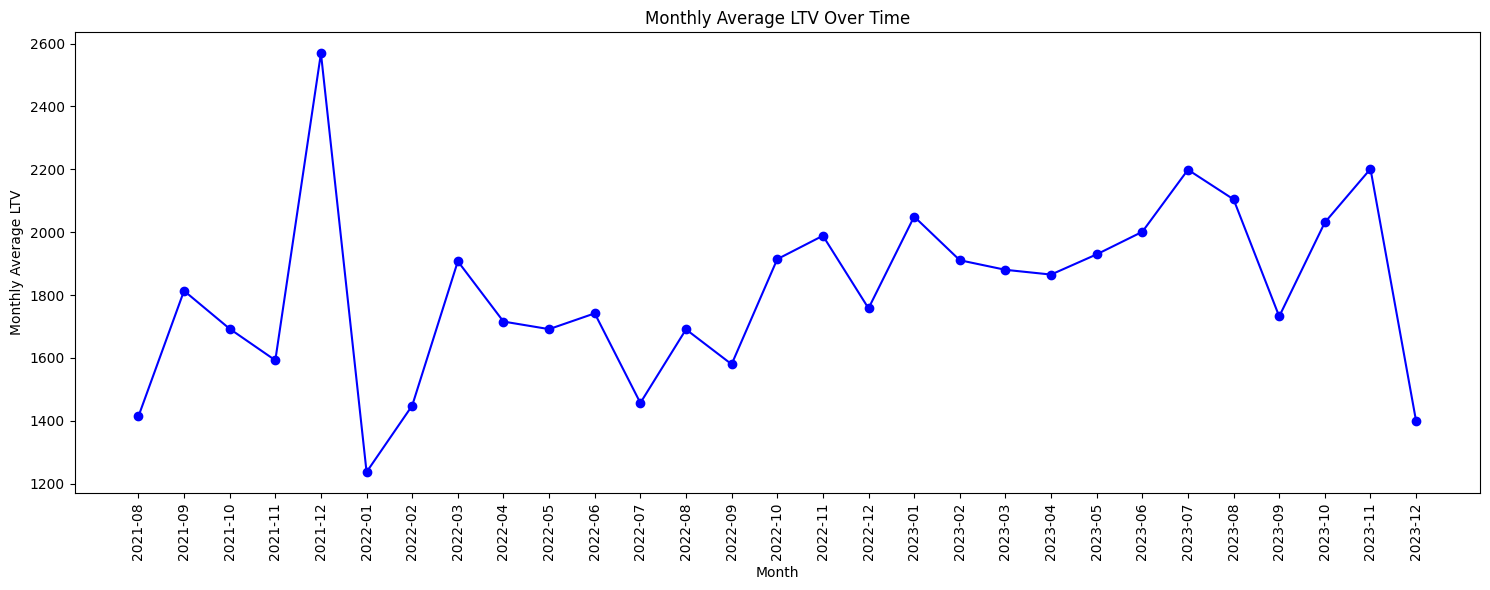

In [16]:
monthly_avg_ltv['order_date'] = monthly_avg_ltv['order_date'].dt.to_timestamp().dt.strftime("%Y-%m")
plt.figure(figsize=(15, 6))
plt.plot(monthly_avg_ltv['order_date'], monthly_avg_ltv['Monthly_Average_LTV'], marker='o', linestyle='-', color='b')
plt.xlabel('Month')
plt.ylabel('Monthly Average LTV')
plt.title('Monthly Average LTV Over Time')
plt.xticks(monthly_avg_ltv['order_date'], rotation=90)

plt.tight_layout()
plt.show()

In [17]:
# monthly_avg_ltv = monthly_ltv.groupby(["year", "month"]).agg(
#     avg_LTV = pd.NamedAgg(column = "order_amount", aggfunc = 'mean')).reset_index()

In [18]:
# monthly_avg_ltv['yearmonth'] = monthly_avg_ltv['year'].astype(str) + monthly_avg_ltv['month'].astype(str).str.zfill(2)

# # Convert 'yearmonth' to datetime
# monthly_avg_ltv['yearmonth'] = pd.to_datetime(monthly_avg_ltv['yearmonth'], format='%Y%m')

# Plot 'yearmonth' vs. 'avg_LTV'
plt.figure(figsize=(25, 6))
# plt.plot(monthly_avg_ltv['order_date'], monthly_avg_ltv['Monthly_Average_LTV'], marker='o', linestyle='-')
# plt.title('Year-Month vs. Average LTV')
# plt.xlabel('Year-Month')
# plt.ylabel('Average LTV')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# monthly_avg_ltv['order_date'] = monthly_avg_ltv['order_date'].dt.to_timestamp()
monthly_avg_ltv['order_date'] = pd.to_datetime(monthly_avg_ltv['order_date'], format='%Y%m')
plt.plot(monthly_avg_ltv['order_date'], monthly_avg_ltv['Monthly_Average_LTV'], marker='o', linestyle='-')
plt.xlabel('Order Date (Month)')
plt.ylabel('Monthly Average LTV')
plt.title('Monthly Average LTV Over Time')
plt.xticks(rotation=45)

# Show the plot
plt.show()

ValueError: time data "2021-08" doesn't match format "%Y%m", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

<Figure size 2500x600 with 0 Axes>

In [19]:
monthly_avg_ltv

,order_date,Monthly_Average_LTV
0,2021-08,1413.625000
1,2021-09,1813.428571
2,2021-10,1692.487805
3,2021-11,1592.263158
4,2021-12,2569.200000
5,2022-01,1236.756098
6,2022-02,1448.263889
7,2022-03,1907.301370
8,2022-04,1715.552941
9,2022-05,1691.425743


In [20]:
# Alert
year = monthly_avg_ltv["year"].tolist()[-1]
month = monthly_avg_ltv["month"].tolist()[-1]
avg_LTV = monthly_avg_ltv["avg_LTV"].tolist()[-1]
year_6 = monthly_avg_ltv["year"].tolist()[-6]
month_6 = monthly_avg_ltv["month"].tolist()[-6]
LTV_6 = monthly_avg_ltv["avg_LTV"].tolist()[-6:]
avg_LTV_6 = sum(LTV_6) / len(LTV_6)
print(f"The average Life Time Value of Customers for the last month {year}-{month} is {avg_LTV}")
print(f"The average Life Time Value of Customers for the last 6 months {year_6}-{month_6} to {year}-{month} is {avg_LTV_6}")

KeyError: 'year'